In [6]:
# ----------------------------
# Import Libraries
# ----------------------------
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from scipy.stats import norm
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
import tqdm
# ----------------------------
# Load and prepare data
# ----------------------------
def load_data(file_path):
    data = pd.read_csv(file_path)
    X = data[['time', 'temp', 'sulf', 'anly']].values
    y = data['yield product'].values
    return X, y
# ----------------------------
# Aquisition Functions
# ----------------------------
def expected_improvement(mu, sigma, y_max):
    with np.errstate(divide='warn'):
        Z = (mu - y_max) / (sigma + 1e-9)
        ei = (mu - y_max) * norm.cdf(Z) + sigma * norm.pdf(Z)
    return ei

def upper_confidence_bound(mu, sigma, kappa=2.0):
    return mu + kappa * sigma

def probability_of_improvement(mu, sigma, y_max):
    with np.errstate(divide='warn'):
        Z = (mu - y_max) / (sigma + 1e-9)
        pi = norm.cdf(Z)
    return pi

def random_acquisition(X_pool):
    return np.random.randint(0, len(X_pool))
# ----------------------------
# Single BO loop supported for parallel execution
# ----------------------------

def run_bo_loop(X_pool, y_pool, model_class, model_params, n_iterations=20, init_size=5, acq_func='ei', seed=42):
    np.random.seed(seed)
    model = model_class(**model_params)
    init_idx = np.random.choice(range(len(X_pool)), size=init_size, replace=False)
    X_train = X_pool[init_idx]
    y_train = y_pool[init_idx]
    mask = np.ones(len(X_pool), dtype=bool)
    mask[init_idx] = False
    X_test = X_pool[mask]
    y_test = y_pool[mask]
    
    best_so_far = []
    improvements = []
    cum_sum_var = []
    root_mean_squares = []
    true_best = y_pool.max()

    for i in range(n_iterations):
        model.fit(X_train, y_train)

        if isinstance(model, GaussianProcessRegressor):
            mu, sigma = model.predict(X_test, return_std=True)
        elif isinstance(model, RandomForestRegressor):
            all_preds = np.stack([tree.predict(X_test) for tree in model.estimators_], axis=0)
            mu = np.mean(all_preds, axis=0)
            sigma = np.std(all_preds, axis=0)
        elif isinstance(model, GradientBoostingRegressor):
            all_preds = np.stack([est[0].predict(X_test) for est in model.estimators_], axis=0)
            mu = np.mean(all_preds, axis=0)
            sigma = np.std(all_preds, axis=0)
        else:
            raise ValueError("Unsupported model type")

        if acq_func == 'ei':
            acq_values = expected_improvement(mu, sigma, y_train.max())
            next_idx = np.argmax(acq_values)
        elif acq_func == 'ucb':
            acq_values = upper_confidence_bound(mu, sigma, kappa=2.0)
            next_idx = np.argmax(acq_values)
        elif acq_func == 'pi':
            acq_values = probability_of_improvement(mu, sigma, y_train.max())
            next_idx = np.argmax(acq_values)
        elif acq_func == 'random':
            next_idx  = random_acquisition(X_test)
        else:
            raise ValueError(f"Unsupported acquisition function: {acq_func}")

        rmse = np.sqrt(np.mean((mu - y_test)**2))
        
        X_train = np.vstack([X_train, X_test[next_idx]])
        y_train = np.append(y_train, y_test[next_idx])
        X_test = np.delete(X_test, next_idx, axis=0)
        y_test = np.delete(y_test, next_idx, axis=0)

        improvement = (true_best - y_train.max())
        cumulative_improvement = np.sum(sigma)
        
    
        best_so_far.append(y_train.max())
        improvements.append(improvement)
        cum_sum_var.append(cumulative_improvement)
        root_mean_squares.append(rmse)

    return best_so_far, root_mean_squares, cum_sum_var

# ----------------------------
# Run multiple BO loops in parallel
# ----------------------------
def run_multiple_bo(X_pool, y_pool, model_class, model_params, acq_func, n_runs=10, n_iterations=20, max_workers=8):
    all_best = []
    all_improvements = []
    all_vars = []
    
    progress = tqdm.tqdm(total=n_runs, desc="Running BO loops")
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(run_bo_loop, X_pool, y_pool, model_class, model_params, n_iterations, 5, acq_func, seed)
            for seed in range(n_runs)
        ]

        for future in as_completed(futures):
            progress.update(1)
            best_so_far, improvements, mean_posterior_vars = future.result()
            all_best.append(best_so_far)
            all_improvements.append(improvements)
            all_vars.append(mean_posterior_vars)

    return np.array(all_best), np.array(all_improvements), np.array(all_vars)

# ----------------------------
# Plot results
# ----------------------------
def plot_results_besty(results, random_results, n_iterations):
    for model_name, data in results.items():
        best_matrix = data['best']  # shape (n_runs, n_iterations)
        random_materix = random_results[0]  # shape (n_runs, n_iterations)
        # Plot mean ± std best-so-far
        mean_best = np.mean(best_matrix, axis=0)
        std_best = np.std(best_matrix, axis=0)
        random_mean_best = np.mean(random_materix, axis=0)
        random_std_best = np.std(random_materix, axis=0)
        
        plt.plot(mean_best, label=f'{model_name} (avg)')
        plt.fill_between(range(n_iterations), mean_best - std_best, mean_best + std_best, alpha=0.2)
        plt.plot(random_mean_best, label=f'{model_name} (avg)', color ='gray', linestyle='--')
        plt.fill_between(range(n_iterations), random_mean_best - random_std_best, random_mean_best + random_std_best, alpha=0.2, color='gray')
        plt.xlabel('Iteration')
        plt.ylabel('Best-So-Far')
        plt.legend()
        plt.title(f'{model_name} - Best-So-Far')

        # Add additional plots here (improvements, variance, etc.)
    plt.show()
    
def plot_results_improvement(results, n_iterations):
    for model_name, data in results.items():
        improvements = data['improvements']
        # Plot mean ± std best-so-far
        mean_best = np.mean(improvements, axis=0)
        std_best = np.std(improvements, axis=0)

        plt.plot(range(n_iterations),mean_best, label=f'{model_name} (avg)')
        plt.fill_between(range(n_iterations), mean_best - std_best, mean_best + std_best, alpha=0.2)
        plt.xlabel('Iteration')
        plt.ylabel('RMSE')
        plt.legend()
        plt.title(f'{model_name} - Improvement')

        # Add additional plots here (improvements, variance, etc.)
    plt.show()

def plot_results_cumvar(results, n_iterations):
    for model_name, data in results.items():
        variance = data['variance']

        # Plot mean ± std best-so-far
        mean_best = np.mean(variance, axis=0)
        std_best = np.std(variance, axis=0)

        plt.plot(range(n_iterations),mean_best, label=f'{model_name} (avg)')
        plt.fill_between(range(n_iterations), mean_best - std_best, mean_best + std_best, alpha=0.2)
        plt.xlabel('Iteration')
        plt.ylabel('Cumulative Variance ')
        plt.legend()
        plt.title(f'{model_name} - Cumulative Variance')

        # Add additional plots here (improvements, variance, etc.)
    plt.show()

def combined_plots(results, n_iterations, colors=['tab:blue', 'tab:orange', 'tab:red']):
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    for model_name, data in results.items():
        # Best-So-Far
        best_matrix = data['best']
        mean_best = np.mean(best_matrix, axis=0)
        std_best = np.std(best_matrix, axis=0)
        color = colors[list(results.keys()).index(model_name) % len(colors)]
        print(color)
        axs[0].plot(mean_best, label=f'{model_name} (avg)', color=color)
        axs[0].fill_between(range(n_iterations), mean_best - std_best, mean_best + std_best, alpha=0.2, color=color)
        axs[0].set_xlabel('Iteration')
        axs[0].set_ylabel('Best-So-Far')
        axs[0].set_title('Best-So-Far')
        axs[0].legend()

        # RMSE (Improvements)
        improvements = data['improvements']
        mean_improv = np.mean(improvements, axis=0)
        std_improv = np.std(improvements, axis=0)
        axs[1].plot(mean_improv, label=f'{model_name} (avg)', color=color)
        axs[1].fill_between(range(n_iterations), mean_improv - std_improv, mean_improv + std_improv, alpha=0.2, color=color)
        axs[1].set_xlabel('Iteration')
        axs[1].set_ylabel('RMSE')
        axs[1].set_title('Root Mean Square Error (RMSE)')


        # Cumulative Variance
        variance = data['variance']
        mean_var = np.mean(variance, axis=0)
        std_var = np.std(variance, axis=0)
        axs[2].plot(mean_var, label=f'{model_name} (avg)', color=color)
        axs[2].fill_between(range(n_iterations), mean_var - std_var, mean_var + std_var, alpha=0.2,color=color)
        axs[2].set_xlabel('Iteration')
        axs[2].set_ylabel('Cumulative Variance')
        axs[2].set_title('Cumulative Variance')
  

    plt.tight_layout()
    plt.show()

def combined_aquisition_plots(results, n_iterations, colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red']):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    for aqui_name, data in results.items():
        # Best-So-Far
        best_matrix = data['best']
        mean_best = np.mean(best_matrix, axis=0)
        std_best = np.std(best_matrix, axis=0)
        axs[0].plot(mean_best, label=f'{aqui_name} (avg)')
        axs[0].fill_between(range(n_iterations), mean_best - std_best, mean_best + std_best, alpha=0.2)
        axs[0].set_xlabel('Iteration')
        axs[0].set_ylabel('Best-So-Far')
        axs[0].set_title('Best-So-Far')
        axs[0].legend()

        # RMSE (Improvements)
        improvements = data['improvements']
        mean_improv = np.mean(improvements, axis=0)
        std_improv = np.std(improvements, axis=0)
        axs[1].plot(mean_improv, label=f'{aqui_name} (avg)')
        axs[1].fill_between(range(n_iterations), mean_improv - std_improv, mean_improv + std_improv, alpha=0.2)
        axs[1].set_xlabel('Iteration')
        axs[1].set_ylabel('RMSE')
        axs[1].set_title('Root Mean Square Error (RMSE)')


        # Cumulative Variance
        variance = data['variance']
        mean_var = np.mean(variance, axis=0)
        std_var = np.std(variance, axis=0)
        axs[2].plot(mean_var, label=f'{aqui_name} (avg)')
        axs[2].fill_between(range(n_iterations), mean_var - std_var, mean_var + std_var, alpha=0.2)
        axs[2].set_xlabel('Iteration')
        axs[2].set_ylabel('Cumulative Variance')
        axs[2].set_title('Cumulative Variance')
  

    plt.tight_layout()
    plt.show()
    



=== Acquisition Function: EI ===
Running Gaussian Process BO...


Running BO loops: 100%|██████████| 50/50 [00:03<00:00, 14.63it/s]


Running Random Forest BO...


Running BO loops: 100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


tab:blue
tab:orange


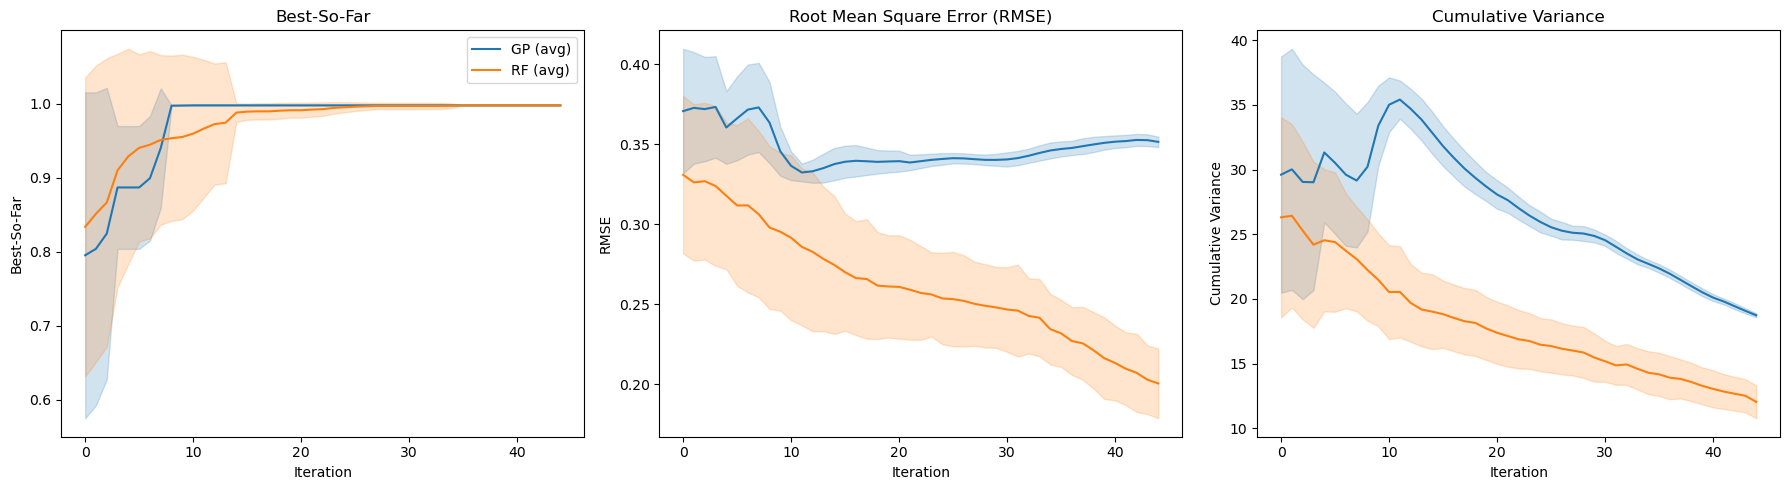

In [2]:
X_pool, y_pool = load_data('../all_data.csv')
n_runs = 50
n_iterations = 45
gp_params = {'kernel': C(1.0) * RBF(), 'alpha': 1e-6, 'normalize_y': True}
rf_params = {'n_estimators': 100, 'random_state': 10}
gb_params = {'n_estimators': 100, 'random_state': 10}

gp = GaussianProcessRegressor
rf = RandomForestRegressor
gb = GradientBoostingRegressor

acq_funcs = ['ei']#['ei', 'ucb', 'random']

for acq in acq_funcs:
    print(f"\n=== Acquisition Function: {acq.upper()} ===")
    results = {}

    print("Running Gaussian Process BO...")
    gp_best, gp_improv, gp_var = run_multiple_bo(
        X_pool, y_pool, gp, gp_params, acq,
        n_runs=n_runs, n_iterations=n_iterations
    )
    results['GP'] = {
        'best': gp_best,
        'improvements': gp_improv,
        'variance': gp_var
    }

    print("Running Random Forest BO...")
    rf_best, rf_improv, rf_var = run_multiple_bo(
        X_pool, y_pool, rf, rf_params, acq,
        n_runs=n_runs, n_iterations=n_iterations,
    )
    results['RF'] = {
        'best': rf_best,
        'improvements': rf_improv,
        'variance': rf_var
    }
    combined_plots(results, n_iterations)
    # print("Running Gradient Boosting BO...")
    # gb_best, gb_improv, gb_var = run_multiple_bo(
    #     X_pool, y_pool, gb, gb_params, acq,
    #     n_runs=n_runs, n_iterations=n_iterations,
    # )
    # results['GB'] = {
    #     'best': gb_best,
    #     'improvements': gb_improv,
    #     'variance': gb_var
    # }

    # Send structured results to your plotting function
    # plot_results_besty(results, n_iterations)
    # plot_results_improvement(results, n_iterations)
    # plot_results_cumvar(results, n_iterations)


tab:blue
tab:orange


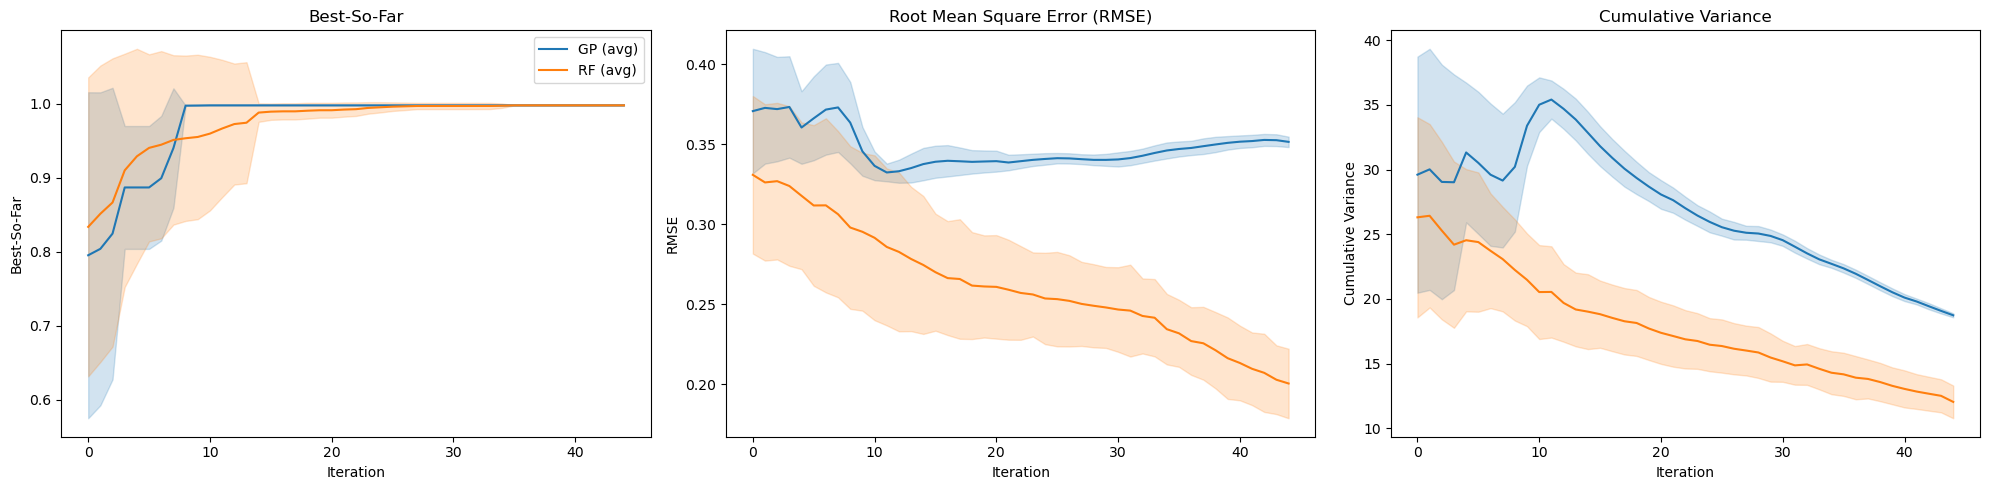

In [7]:
combined_plots(results, n_iterations)

In [ ]:
X_pool, y_pool = load_data('../all_data.csv')
n_runs = 50
n_iterations = 45
gp_params = {'kernel': C(1.0) * RBF(), 'alpha': 1e-6, 'normalize_y': True}
rf_params = {'n_estimators': 100, 'random_state': 10}
gb_params = {'n_estimators': 100, 'random_state': 10}

gp = GaussianProcessRegressor
rf = RandomForestRegressor
gb = GradientBoostingRegressor

acq_funcs = ['ei', 'ucb', 'pi','random']

results = {}

print("Running Gaussian Process BO...")
gp_best, gp_improv, gp_var = run_multiple_bo(X_pool, y_pool, gp, gp_params, 'ei', n_runs=n_runs, n_iterations=n_iterations )
results['ei'] = {
    'best': gp_best,
    'improvements': gp_improv,
    'variance': gp_var
}
gp_best, gp_improv, gp_var = run_multiple_bo(X_pool, y_pool, gp, gp_params, 'ucb', n_runs=n_runs, n_iterations=n_iterations )
results['ucb'] = {
    'best': gp_best,
    'improvements': gp_improv,
    'variance': gp_var
}
gp_best, gp_improv, gp_var = run_multiple_bo(X_pool, y_pool, gp, gp_params, 'pi', n_runs=n_runs, n_iterations=n_iterations )
results['pi'] = {
    'best': gp_best,
    'improvements': gp_improv,
    'variance': gp_var
}
gp_best, gp_improv, gp_var = run_multiple_bo(X_pool, y_pool, gp, gp_params, 'random', n_runs=n_runs, n_iterations=n_iterations )
results['random'] = {
    'best': gp_best,
    'improvements': gp_improv,
    'variance': gp_var
}




=== Acquisition Function: RANDOM ===
Running Gaussian Process BO...


Running BO loops: 100%|██████████| 50/50 [00:03<00:00, 12.87it/s]


In [ ]:
combined_aquisition_plots(results, n_iterations)

NameError: name 'results' is not defined


=== Acquisition Function: EI ===
Running Gaussian Process BO...


Running BO loops: 100%|██████████| 50/50 [00:04<00:00, 11.42it/s]


Running Random Forest BO...


Running BO loops: 100%|██████████| 50/50 [01:39<00:00,  1.99s/it]


Running Gradient Boosting BO...


Running BO loops: 100%|██████████| 50/50 [00:57<00:00,  1.14s/it]


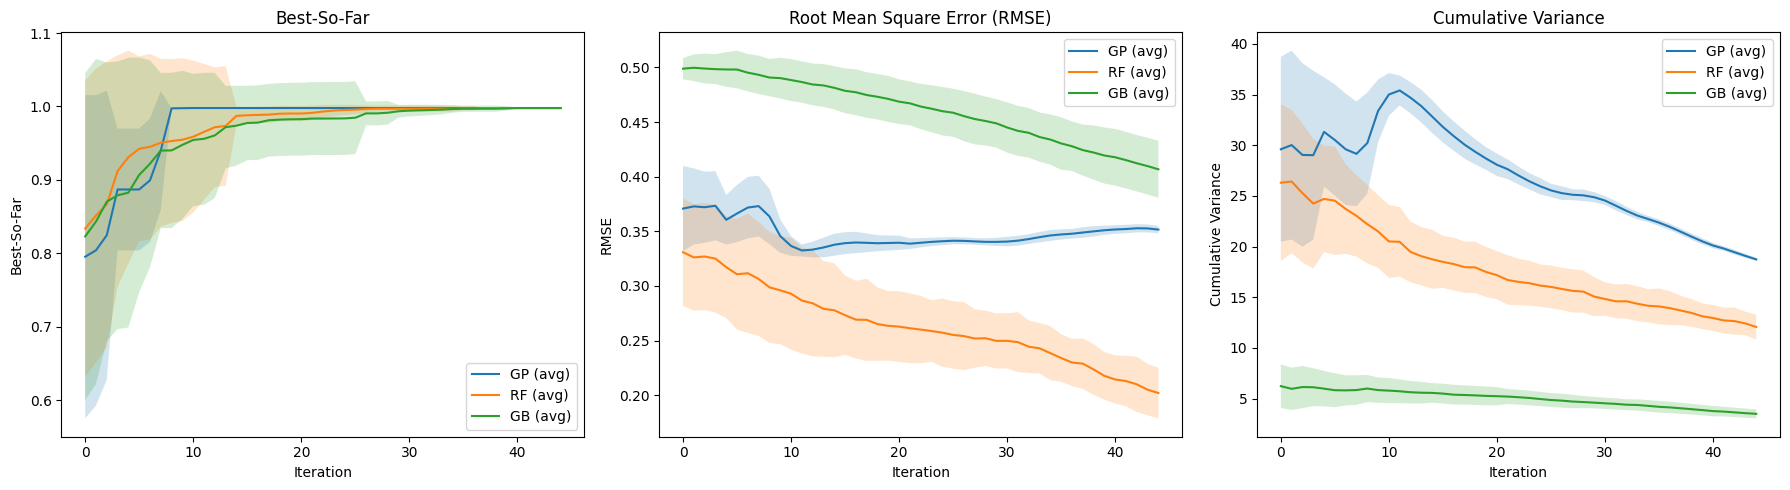


=== Acquisition Function: UCB ===
Running Gaussian Process BO...


Running BO loops: 100%|██████████| 50/50 [00:03<00:00, 12.60it/s]


Running Random Forest BO...


Running BO loops: 100%|██████████| 50/50 [01:39<00:00,  2.00s/it]


Running Gradient Boosting BO...


Running BO loops: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


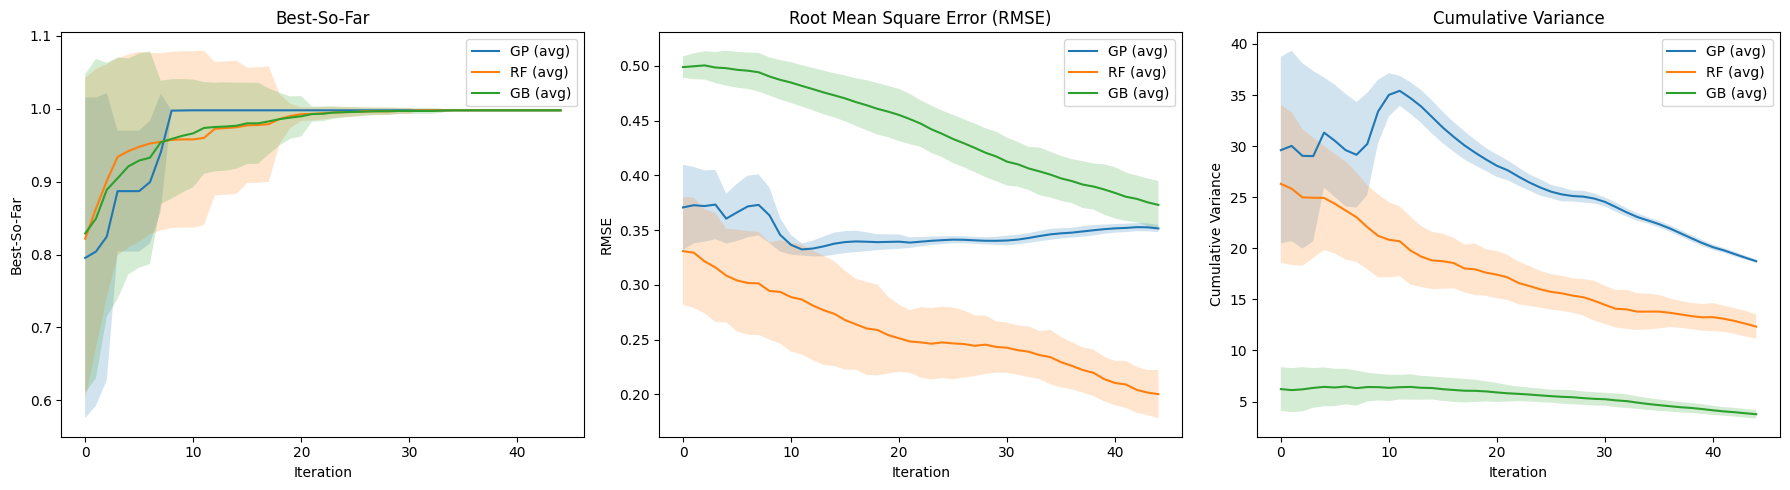


=== Acquisition Function: PI ===
Running Gaussian Process BO...


Running BO loops: 100%|██████████| 50/50 [00:04<00:00, 11.29it/s]


Running Random Forest BO...


Running BO loops: 100%|██████████| 50/50 [01:35<00:00,  1.91s/it]


Running Gradient Boosting BO...


Running BO loops: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]


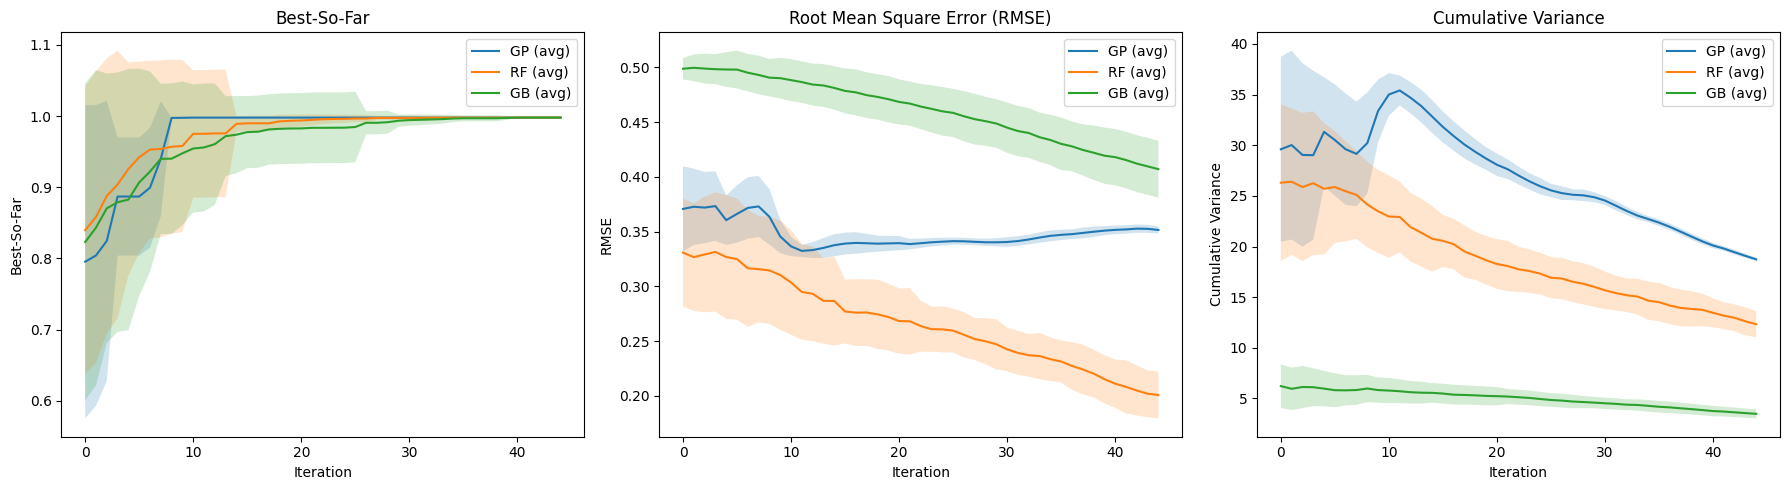

In [ ]:
def main():
    X_pool, y_pool = load_data('../all_data.csv')
    n_runs = 50
    n_iterations = 45
    gp_params = {'kernel': C(1.0) * RBF(), 'alpha': 1e-6, 'normalize_y': True}
    rf_params = {'n_estimators': 100, 'random_state': 10}
    gb_params = {'n_estimators': 100, 'random_state': 10}

    gp = GaussianProcessRegressor
    rf = RandomForestRegressor
    gb = GradientBoostingRegressor

    acq_funcs = ['ei', 'ucb', 'pi']

    for acq in acq_funcs:
        print(f"\n=== Acquisition Function: {acq.upper()} ===")
        results = {}

        print("Running Gaussian Process BO...")
        gp_best, gp_improv, gp_var = run_multiple_bo(
            X_pool, y_pool, gp, gp_params, acq,
            n_runs=n_runs, n_iterations=n_iterations
        )
        results['GP'] = {
            'best': gp_best,
            'improvements': gp_improv,
            'variance': gp_var
        }

        print("Running Random Forest BO...")
        rf_best, rf_improv, rf_var = run_multiple_bo(
            X_pool, y_pool, rf, rf_params, acq,
            n_runs=n_runs, n_iterations=n_iterations,
        )
        results['RF'] = {
            'best': rf_best,
            'improvements': rf_improv,
            'variance': rf_var
        }

        # print("Running Gradient Boosting BO...")
        # gb_best, gb_improv, gb_var = run_multiple_bo(
        #     X_pool, y_pool, gb, gb_params, acq,
        #     n_runs=n_runs, n_iterations=n_iterations,
        # )
        # results['GB'] = {
        #     'best': gb_best,
        #     'improvements': gb_improv,
        #     'variance': gb_var
        # }

        # Send structured results to your plotting function
        # plot_results_besty(results, n_iterations)
        # plot_results_improvement(results, n_iterations)
        # plot_results_cumvar(results, n_iterations)
        combined_plots(results, n_iterations)
if __name__ == "__main__":
    main()

In [ ]:
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
# File Tools for local
import pandas as pd
# Random seed for reproducibility
import random
import torch
from botorch.utils.transforms import unnormalize, normalize
#from BOClass import Models, Plotting, PoolObjectives
from boclass_query import Models, Plotting, PoolObjectives


dtype = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
all_data = pd.read_csv('../all_data.csv') # all_df = pd.concat([data01, data2A, data2B, data2C, data3A, data3B, data3C], axis=0, ignore_index=True)
data01 = all_data[:15]
data2A = all_data[15:30]
data2B = all_data[30:45]
data2C = all_data[45:60]
data3A = all_data[60:75]
data3B = all_data[75:90]
data3C = all_data[90:105]
# Model Sets
set_dataA = pd.concat([data01, data2A, data3A], axis=0, ignore_index=True)
set_dataB = pd.concat([data01, data2B, data3B], axis=0,ignore_index=True)
set_dataC = pd.concat([data01, data2C, data3C], axis=0,ignore_index=True)


In [ ]:
random_seed = 5
batch_size = 5
train_size = batch_size

# Iteration 0: Set up gp with initial data
original_bounds = torch.tensor([[30., 20., 75. , 33.], [600., 170., 100.,100.]], dtype=dtype, device=device)

x_inputs = all_data[['time','temp','sulf','anly'] ]
y_outputs = all_data["yield product"]
yvar_outputs = all_data["var yield"]
# Set the device and dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
# Convert to torch tensors
x_all = torch.tensor(x_inputs.to_numpy(), dtype=torch.float32)
nx_all = normalize(x_all,original_bounds)
y_all = torch.tensor(y_outputs.values.reshape(-1, 1), dtype=torch.float32)
yvar_all = torch.tensor(yvar_outputs.values.reshape(-1, 1), dtype=torch.float32)

random.seed(5)
random_indices = random.sample(range(x_all.shape[0]), train_size)
x_train = x_all[random_indices]
nx_train = normalize(x_train, bounds=original_bounds) # normalized data for training

y_train = y_all[random_indices]
y_train_var = yvar_all[random_indices]

# Remove x_train rows from x_inputs
# Convert x_train to numpy for comparison
x_train_np = x_train.cpu().numpy()
# Find all rows in x_inputs that are not in x_train
mask = ~x_inputs.apply(lambda row: ((x_train_np == row.values).all(axis=1)).any(), axis=1)
x_input_new = x_inputs[mask]
y_output_new = y_outputs[mask]
yvar_output_new = yvar_outputs[mask]
query = PoolObjectives(x_input_new, y_output_new ,yvar_output_new, columns=['time', 'temp', 'sulf', 'anly'])
# Step 1: Initialize your model
gp_model = Models(x_train=nx_train, y_train=y_train, y_train_var=y_train_var, bounds=original_bounds, batch_size=batch_size, objective=query)




In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import norm
def BO_rf_loop():
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    num_iterations = 45

    # Ensure numpy inputs
    X_train = nx_train.numpy() if isinstance(nx_train, torch.Tensor) else nx_train
    Y_train = y_train.numpy() if isinstance(y_train, torch.Tensor) else y_train
    Yvar_train = y_train_var.numpy() if isinstance(y_train_var, torch.Tensor) else y_train_var

    store_model = []

    for iteration in range(num_iterations):
        rf.fit(X_train, Y_train)

        all_preds = np.stack([tree.predict(x_all) for tree in rf.estimators_], axis=0)
        mean_pred = np.mean(all_preds, axis=0)
        std_pred = np.std(all_preds, axis=0)

        best_y = np.max(Y_train)
        sigma = std_pred
        with np.errstate(divide='warn'):
            Z = (mean_pred - best_y) / (sigma + 1e-9)
            ei = (mean_pred - best_y) * norm.cdf(Z) + sigma * norm.pdf(Z)
            ei[sigma == 0.0] = 0.0

        next_idx = np.argmax(ei)
        next_x = x_all[next_idx]
        next_nx = nx_all[next_idx]

        next_y = y_all[next_idx].item()
        next_yvar = yvar_all[next_idx].item()

        X_train = np.vstack([X_train, next_nx])
        Y_train = np.append(Y_train, next_y)
        Yvar_train = np.append(Yvar_train, next_yvar)

        store_model.append(rf)


    return rf, X_train, Y_train, Yvar_train

rf_model = Models(x_train=nx_train, y_train=y_train, y_train_var=y_train_var, bounds=original_bounds, batch_size=batch_size, objective=query)
rf_modelBO, train_nxBO_rf, train_yBO_rf, train_yvarBO_rf = BO_rf_loop()

variable_combinations = [('time', 'sulf', 'anly'), ('theta', 'r', 't'), ('n', 't', 'theta')]
plotting = Plotting(rf_modelBO, variable_combinations=variable_combinations, select='RandomForest')
combination = variable_combinations[0]
minmax = [y_train.min(), y_train.max()]
plotting.sliced_plotting(combination, minmax)


In [ ]:
# def main():
#     X_pool, y_pool = load_data('../all_data.csv')
#     n_runs = 20
#     n_iterations = 45
#     gp_params = {'kernel':C(1.0) * RBF(),'alpha': 1e-6, 'normalize_y': True}
#     rf_params = {'n_estimators': 100, 'random_state': 10}
#     pi_params = {'n_estimators': 100, 'random_state': 10}

#     gp = GaussianProcessRegressor
#     rf = RandomForestRegressor
#     gb = GradientBoostingRegressor

#     acq_funcs = ['ei', 'ucb', 'pi']

#     for acq in acq_funcs:
#         print(f"\n=== Acquisition Function: {acq.upper()} ===")
#         results = {}
#         print("Running Gaussian Process BO...")
#         results['GP'] = run_multiple_bo(X_pool, y_pool, gp, gp_params, n_runs=n_runs, n_iterations=n_iterations, acq_func=acq)
#         best_matrix, improvemets, cum_sum_var = results['GP']
#         print("Running Random Forest BO...")
#         results['RF'] = run_multiple_bo(X_pool, y_pool, rf, rf_params, n_runs=n_runs, n_iterations=n_iterations, acq_func=acq)
#         best_matrix, improvemets, cum_sum_var = results['GP']
#         print("Running Gradient Boosting BO...")
#         results['GB'] = run_multiple_bo(X_pool, y_pool, gb, pi_params, n_runs=n_runs, n_iterations=n_iterations, acq_func=acq)
#         best_matrix, improvemets, cum_sum_var = results['GP']

#         plot_results_besty(results, n_iterations)
# if __name__ == "__main__":
#     main()

In [ ]:
# # ----------------------------
# # Load and prepare data
# # ----------------------------
# def load_data(file_path):
#     data = pd.read_csv(file_path)
#     X = data[['time', 'temp', 'sulf', 'anly']].values
#     y = data['yield product'].values
#     return X, y

# # ----------------------------
# # Acquisition functions
# # ----------------------------
# def expected_improvement(mu, sigma, f_best):
#     sigma = sigma + 1e-9  # avoid division by zero
#     Z = (mu - f_best) / sigma
#     ei = (mu - f_best) * norm.cdf(Z) + sigma * norm.pdf(Z)
#     return ei

# def upper_confidence_bound(mu, sigma, kappa=2.0):
#     return mu + kappa * sigma

# def probability_of_improvement(mu, sigma, f_best):
#     sigma = sigma + 1e-9
#     Z = (mu - f_best) / sigma
#     return norm.cdf(Z)


# # ----------------------------
# # Run a single BO loop
# # ----------------------------
# def run_bo_loop(X_pool, y_pool, model, n_iterations=20, init_size=5, acq_func='ei', seed=42):
#     np.random.seed(seed)
#     init_idx = np.random.choice(range(len(X_pool)), size=init_size, replace=False)
#     X_train = X_pool[init_idx]
#     y_train = y_pool[init_idx]
#     mask = np.ones(len(X_pool), dtype=bool)
#     mask[init_idx] = False
#     X_test = X_pool[mask]
#     y_test = y_pool[mask]
    
#     best_so_far = []

#     for i in range(n_iterations):
#         model.fit(X_train, y_train)

#         if isinstance(model, GaussianProcessRegressor):
#             mu, sigma = model.predict(X_test, return_std=True)
#         elif isinstance(model, RandomForestRegressor):
#             all_preds = np.stack([tree.predict(X_test) for tree in model.estimators_], axis=0)
#             mu = np.mean(all_preds, axis=0)
#             sigma = np.std(all_preds, axis=0)
#         elif isinstance(model, GradientBoostingRegressor):
#             all_preds = np.stack([est[0].predict(X_test) for est in model.estimators_], axis=0)
#             mu = np.mean(all_preds, axis=0)
#             sigma = np.std(all_preds, axis=0)
#         else:
#             raise ValueError("Unsupported model type")

#         # Apply selected acquisition function
#         if acq_func == 'ei':
#             acq_values = expected_improvement(mu, sigma, y_train.max())
#         elif acq_func == 'ucb':
#             acq_values = upper_confidence_bound(mu, sigma, kappa=2.0)
#         elif acq_func == 'pi':
#             acq_values = probability_of_improvement(mu, sigma, y_train.max())
#         else:
#             raise ValueError(f"Unsupported acquisition function: {acq_func}")

#         next_idx = np.argmax(acq_values)

#         X_train = np.vstack([X_train, X_test[next_idx]])
#         y_train = np.append(y_train, y_test[next_idx])
#         X_test = np.delete(X_test, next_idx, axis=0)
#         y_test = np.delete(y_test, next_idx, axis=0)

#         best_so_far.append(y_train.max())

#     return best_so_far


# # ----------------------------
# # Run multiple BO runs (averaging)
# # ----------------------------
# def run_multiple_bo(X_pool, y_pool, model, n_runs=10, n_iterations=20, acq_func='ei'):
#     all_runs = []
#     for seed in range(n_runs):
#         best_so_far = run_bo_loop(X_pool, y_pool, model, n_iterations=n_iterations, acq_func=acq_func, seed=seed)
#         all_runs.append(best_so_far)
#     return np.array(all_runs)

# # ----------------------------
# # Plot results
# # ----------------------------
# def plot_results_besty(results_dict, n_iterations):
#     plt.figure(figsize=(8, 3))
#     for model_name, runs in results_dict:
#         mean_curve = np.mean(runs, axis=0)
#         std_curve = np.std(runs, axis=0)
#         plt.plot(mean_curve, label=f'{model_name} (avg)')
#         plt.fill_between(range(n_iterations),
#                          mean_curve - std_curve,
#                          mean_curve + std_curve,
#                          alpha=0.2)
#     plt.xlabel('Iteration')
#     plt.ylabel('Best Yield Found')
#     plt.title('Average BO Performance Across Runs')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# def main():
#     X_pool, y_pool = load_data('../all_data.csv')
#     n_runs = 10
#     n_iterations = 20

#     gp = GaussianProcessRegressor(kernel=C(1.0) * RBF(), alpha=1e-6, normalize_y=True)
#     rf = RandomForestRegressor(n_estimators=100)
#     gb = GradientBoostingRegressor(n_estimators=100)

#     acq_funcs = ['ei', 'ucb', 'pi']

#     for acq in acq_funcs:
#         print(f"\n=== Acquisition Function: {acq.upper()} ===")
#         results = {}
#         print("Running Gaussian Process BO...")
#         results['GP'] = run_multiple_bo(X_pool, y_pool, gp, n_runs, n_iterations, acq_func=acq)
#         print("Running Random Forest BO...")
#         results['RF'] = run_multiple_bo(X_pool, y_pool, rf, n_runs, n_iterations, acq_func=acq)
#         print("Running Gradient Boosting BO...")
#         results['GB'] = run_multiple_bo(X_pool, y_pool, gb, n_runs, n_iterations, acq_func=acq)

#         plot_results_besty(results, n_iterations)
# if __name__ == "__main__":
#     main()


